In [0]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
!pip install tensorflow-gpu==1.15.0

In [0]:
def gr(X, Y, outputs, batch_size):
    for j in range(batch_size):
        plt.figure(figsize=(12, 3))
        
        for k in range(output_dim):
            past = X[:,j,k]
            expected = Y[:,j,k]
            pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" #if k==0 else "_nolegend_"
        label2 = "True future values" #if k==0 else "_nolegend_"
        label3 = "Predictions" #if k==0 else "_nolegend_"
    
        plt.plot(range(len(past)), past , "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected , "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred , "o--y", label=label3)
    
        plt.legend(loc='best')
        plt.title("Predictions v.s. true values")
        plt.show()

In [0]:
def variable_summaries(var): 
    with tf.name_scope('summaries'): 
        mean = tf.reduce_mean(var) 
        tf.summary.scalar('mean', mean) 
        
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean))) 
            
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var)) 
        tf.summary.scalar('min', tf.reduce_min(var)) 
        tf.summary.histogram('histogram', var)

In [0]:
def generate_x_y_data_two_freqs(isTrain , batch_size , seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y

In [0]:
def generate_x_y_data_2(isTrain, batch_size):
    return generate_x_y_data_two_freqs(isTrain, batch_size, seq_length=30)

In [0]:
def generate_x_y_data_3(isTrain , batch_size): 
  seq_length = 30 
  x, y = generate_x_y_data_two_freqs( isTrain , batch_size , seq_length=seq_length) 
  noise_amount = random.random() * 0.15 + 0.10
  x = x + noise_amount * np.random.randn(seq_length , batch_size , 1)
  avg = np.average(x) 
  std = np.std(x) + 0.0001
  x = x - avg 
  y = y - avg 
  x = x / std / 2.5 
  y = y / std / 2.5

  return x, y

In [0]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

tf.reset_default_graph()
# интерактивная сессия
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data_3(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 60
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 50
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 1

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.007
# Количество итераций по обучающей выборке 
nb_iters = 1000
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.93
momentum = 0.3
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-13

In [0]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(seq_length)
    ]

    expected_sparse_output = [
        tf.placeholder(tf.float32 , shape=(None , output_dim), name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32 , name="GO") ] + enc_inp[:-1]
    
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    variable_summaries(w_in)
    variable_summaries(b_in)
    variable_summaries(w_out)
    variable_summaries(b_out)

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [0]:
output_scale_factor = tf.Variable(1.0 , name ="Output_ScaleFactor")
reshaped_outputs = [ output_scale_factor *( tf. matmul (i, w_out ) + b_out ) for i in dec_outputs]
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss
    #tf.summary.scalar('loss', loss)
    
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('lab6' + '/train', graph=tf.get_default_graph())
# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = generate_x_y_data_3(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

Step 0/1000, train loss: 957.5198974609375, 	TEST loss: 3605.587158203125
Step 10/1000, train loss: 130.13558959960938, 	TEST loss: 131.36854553222656
Step 20/1000, train loss: 137.69815063476562, 	TEST loss: 132.1146697998047
Step 30/1000, train loss: 136.04470825195312, 	TEST loss: 140.4432830810547
Step 40/1000, train loss: 127.6760482788086, 	TEST loss: 143.61273193359375
Step 50/1000, train loss: 144.00955200195312, 	TEST loss: 142.0890350341797
Step 60/1000, train loss: 129.14376831054688, 	TEST loss: 138.7416534423828
Step 70/1000, train loss: 131.88671875, 	TEST loss: 125.59944152832031
Step 80/1000, train loss: 131.9893035888672, 	TEST loss: 146.31591796875
Step 90/1000, train loss: 136.89100646972656, 	TEST loss: 146.12147521972656
Step 100/1000, train loss: 135.6554412841797, 	TEST loss: 138.94381713867188
Step 110/1000, train loss: 129.3465576171875, 	TEST loss: 130.83189392089844
Step 120/1000, train loss: 135.8646697998047, 	TEST loss: 138.3379669189453
Step 130/1000, tra

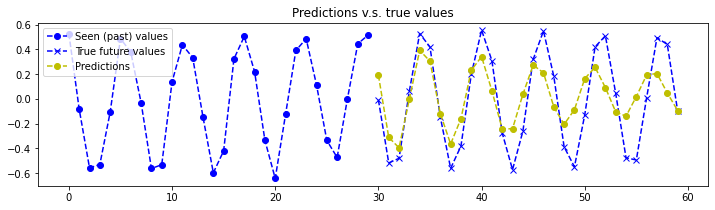

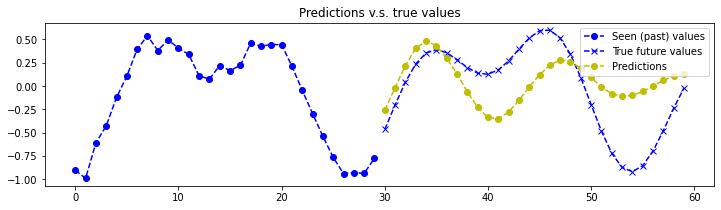

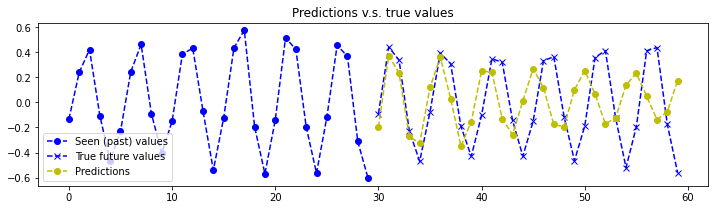

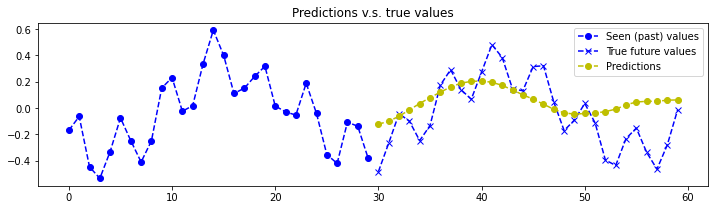

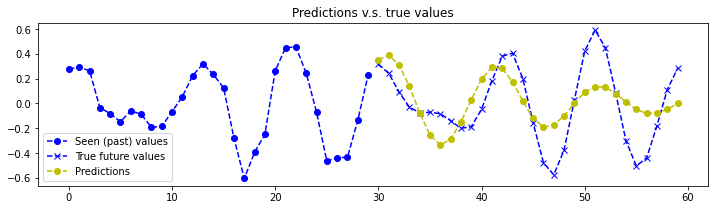

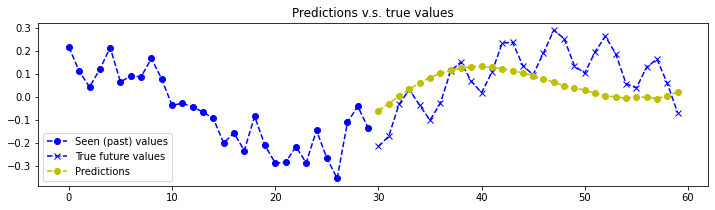

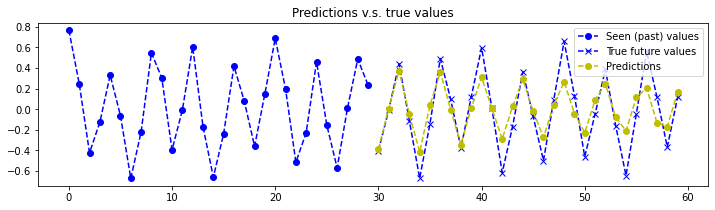

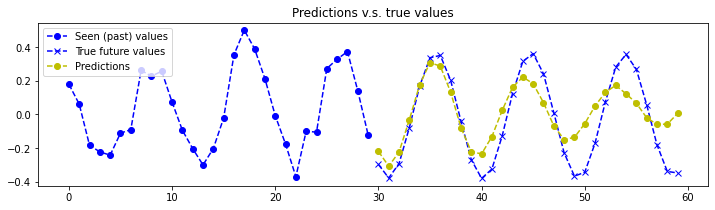

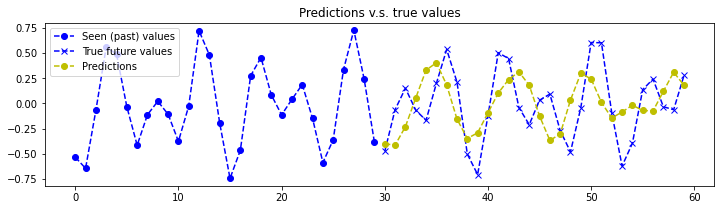

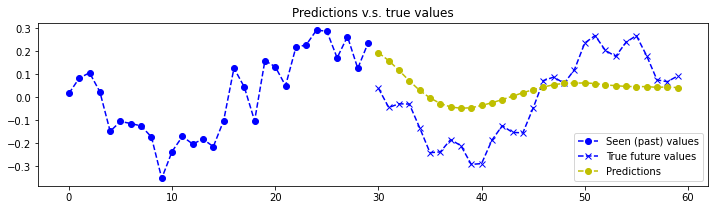

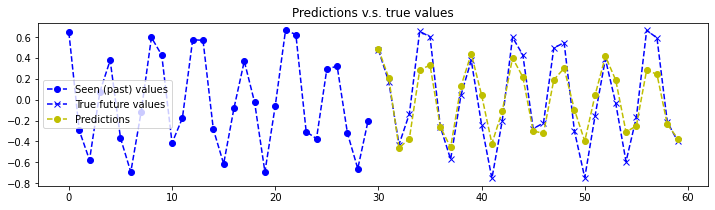

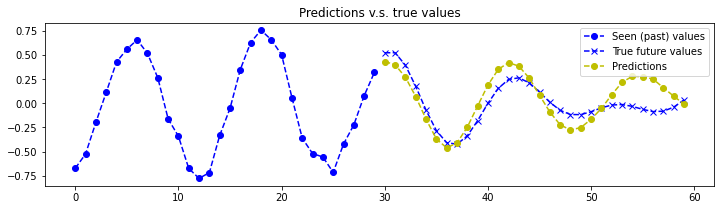

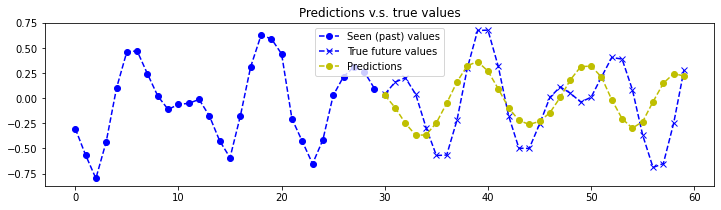

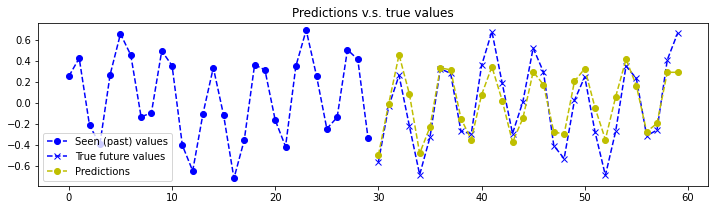

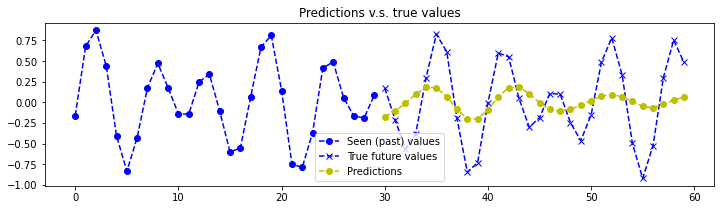

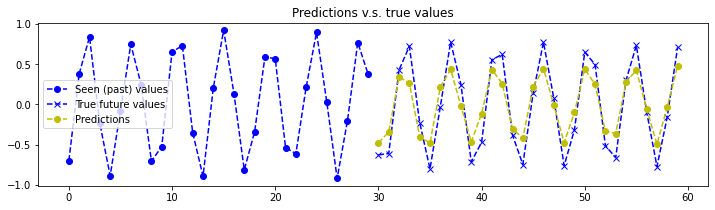

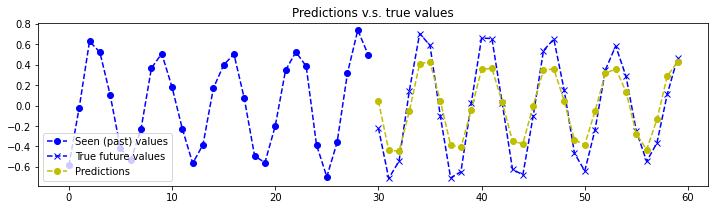

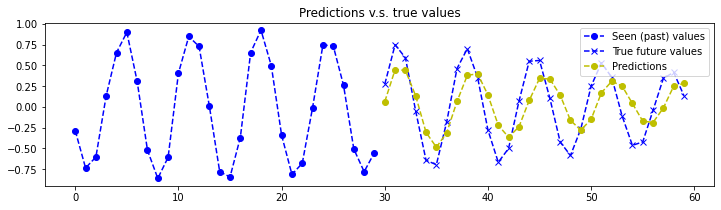

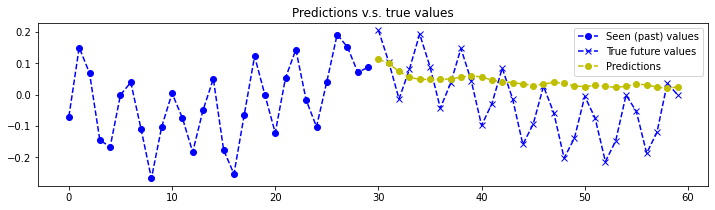

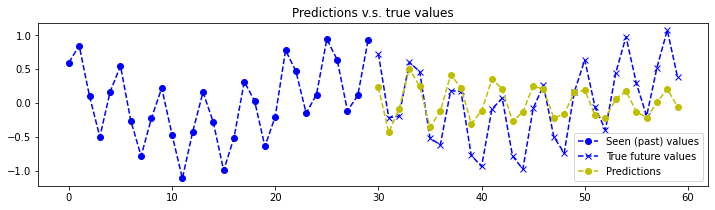

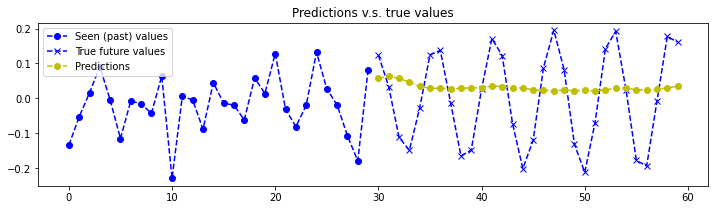

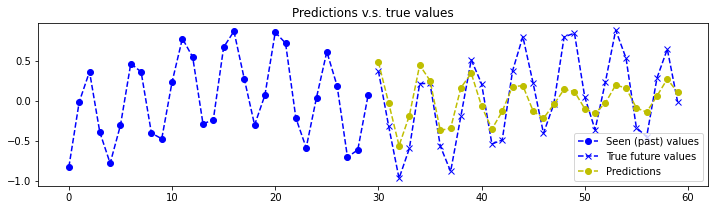

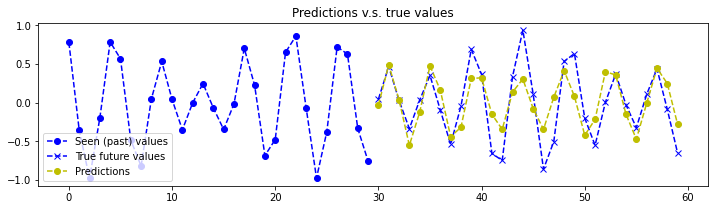

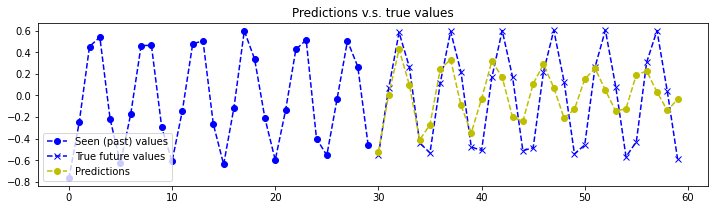

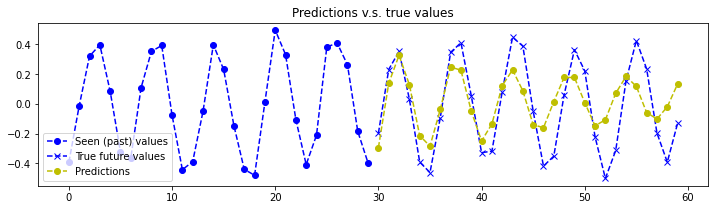

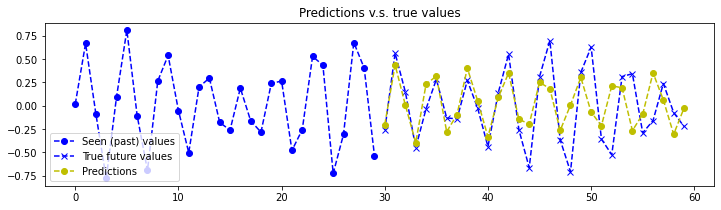

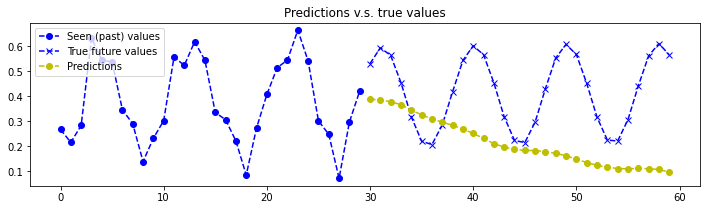

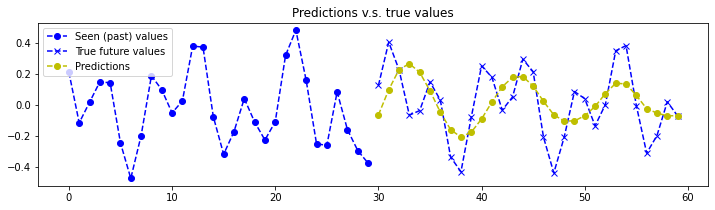

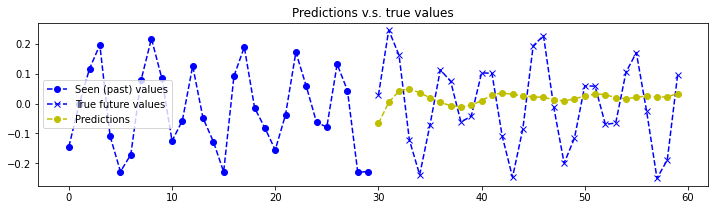

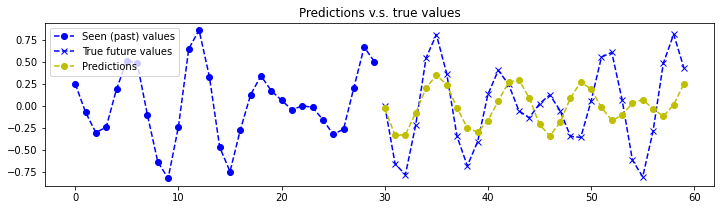

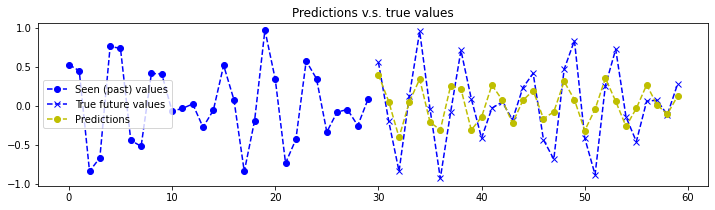

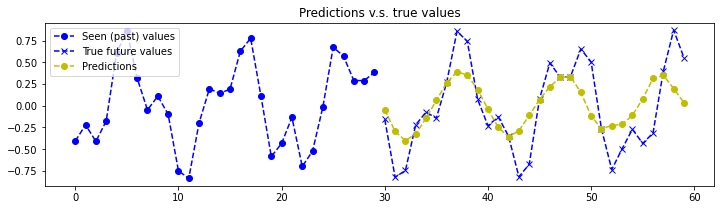

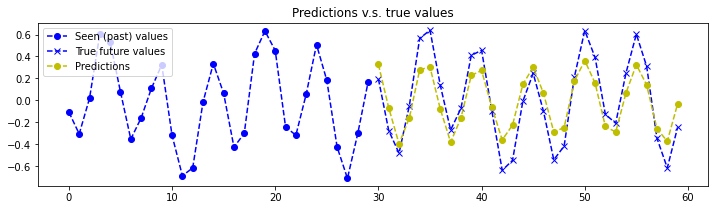

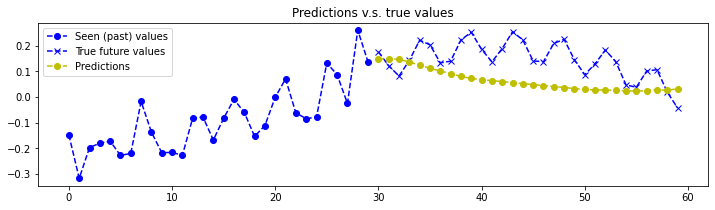

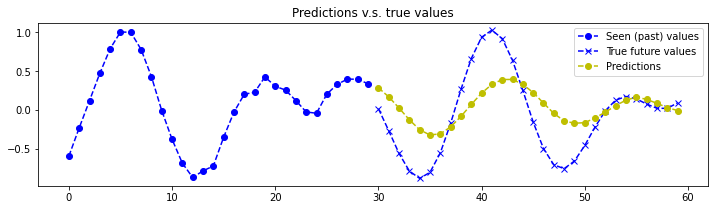

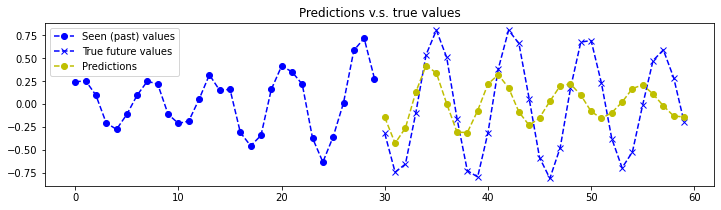

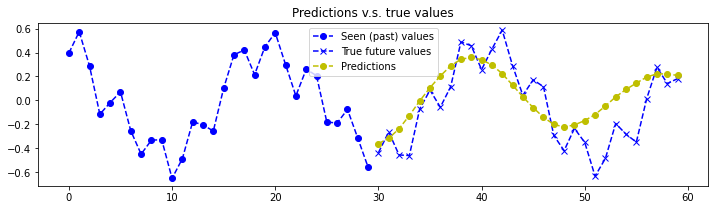

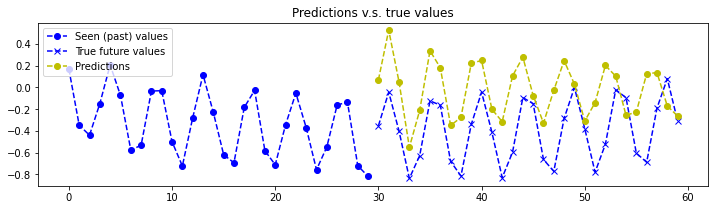

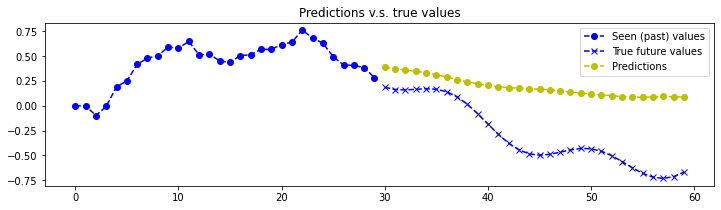

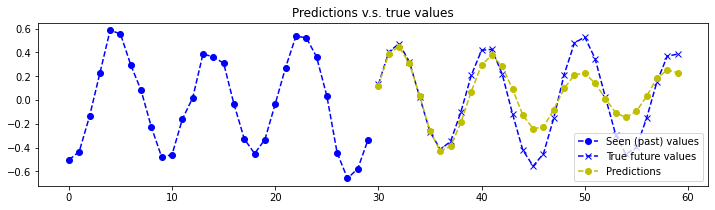

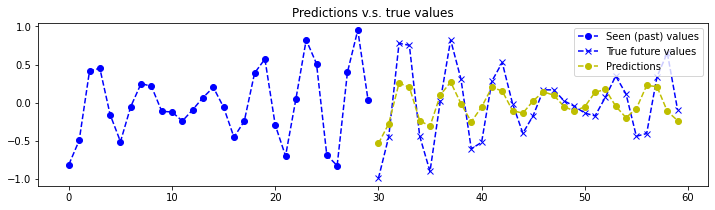

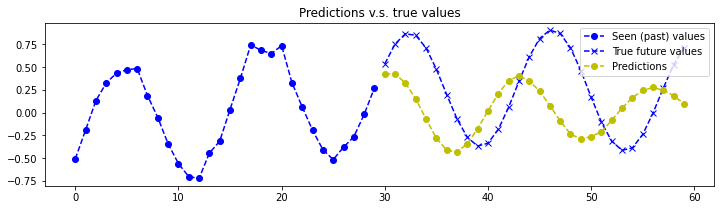

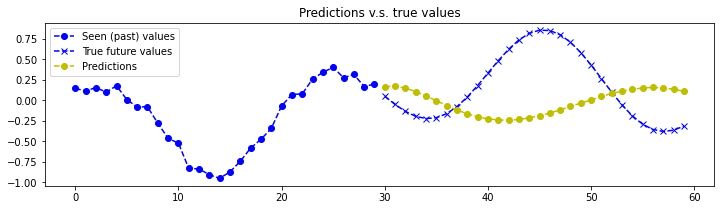

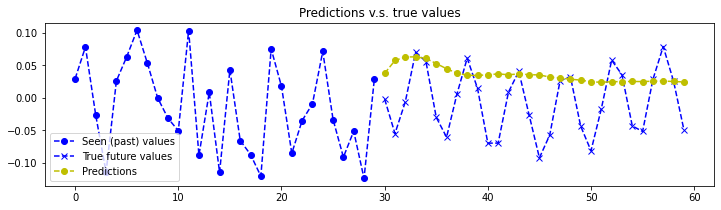

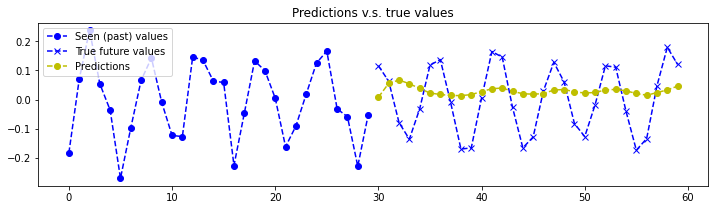

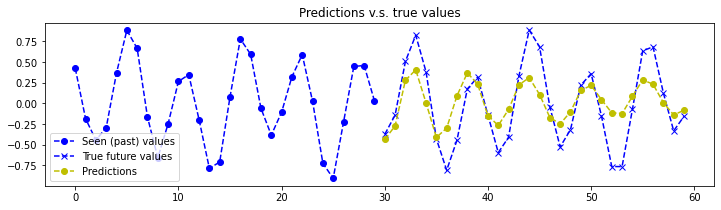

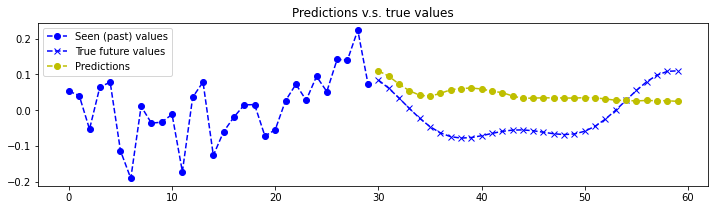

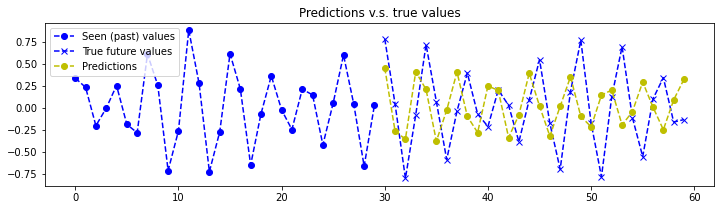

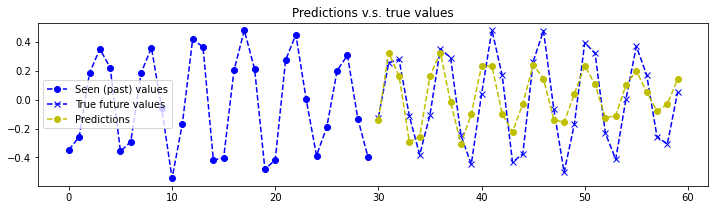

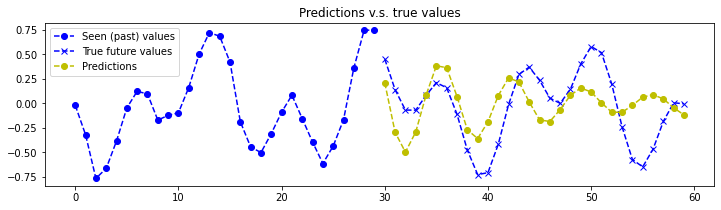

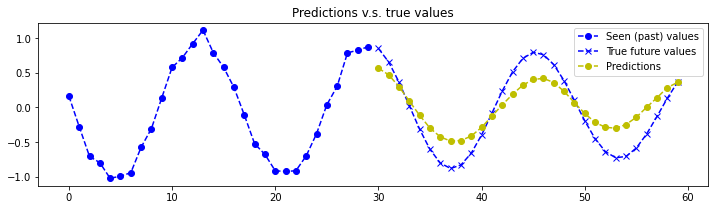

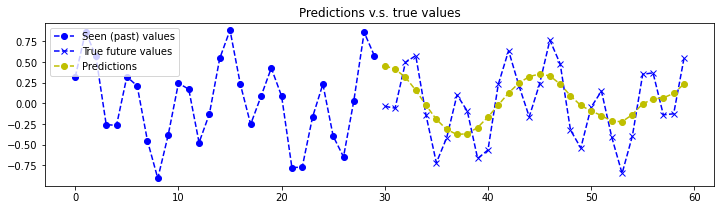

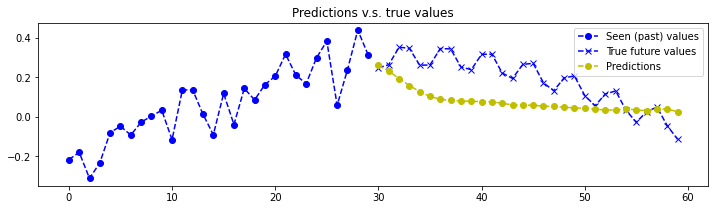

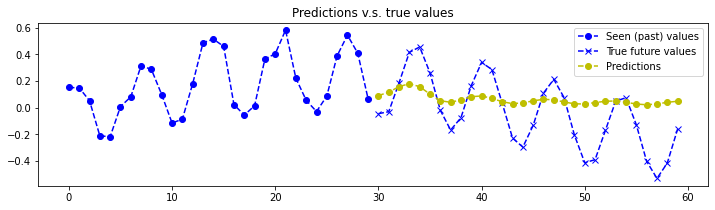

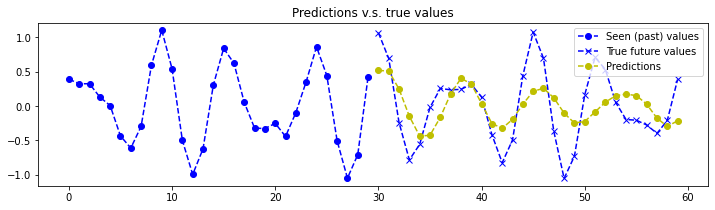

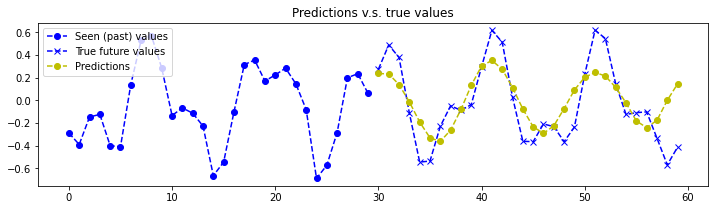

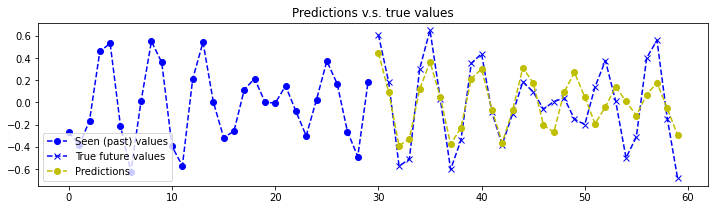

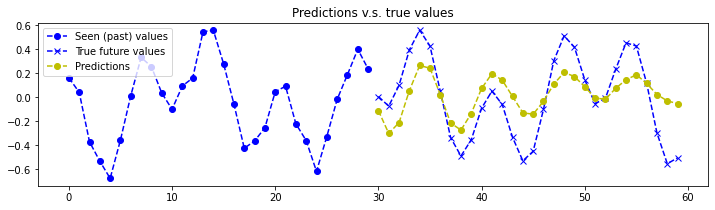

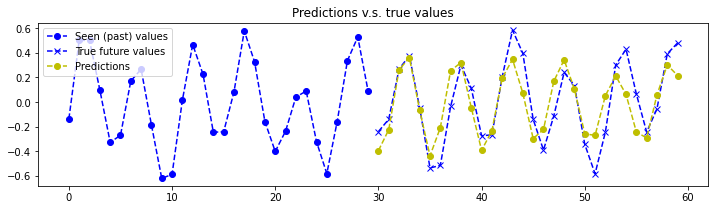

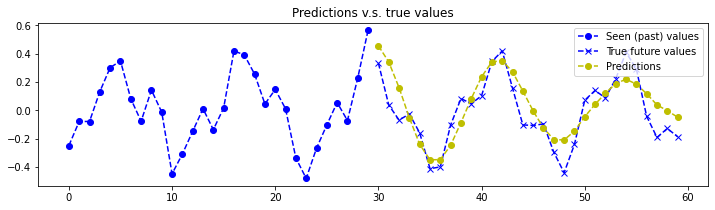

Step 1000/1000, train loss: 94.3806381225586, 	TEST loss: 84.96495819091797
Fin. train loss: 94.3806381225586, 	TEST loss: 84.96495819091797


In [0]:
# Тестовый прогон. Веса не обновляются благодаря тому, что переменная train_op не передается в sess.run
def test_batch(batch_size, graph=False): 
    X, Y = generate_x_y_data_3(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    outputs, loss_t, summ = sess.run([reshaped_outputs, loss, merged], feed_dict)
    
    outputs = np.array(outputs)
    if graph==True:
        gr(X, Y, outputs, batch_size)
    
    return loss_t, summ

train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())

#nb_iters - количество шагов для обучения. После каждых 10 шагов проверяется ошибка на тестовой выборке



for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 10 == 0:
        test_loss, summ = test_batch(batch_size, t==nb_iters)
        test_losses.append(test_loss)
        train_writer.add_summary(summ, t)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters , train_loss , test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss , test_loss))

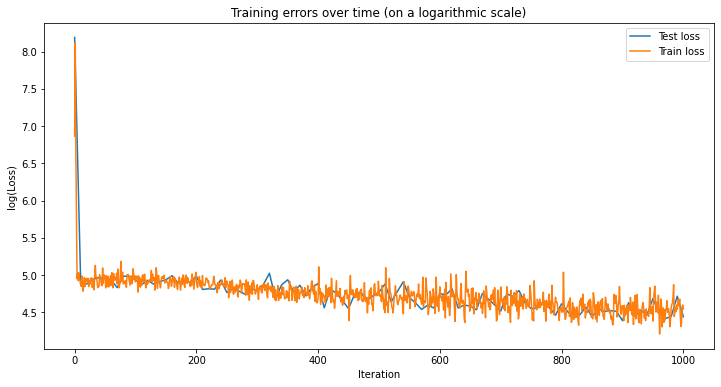

In [0]:
plt.figure(figsize=(12, 6))
plt.plot( 
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss" 
)
plt.plot( 
    np.log(train_losses), 
    label="Train loss" 
)
plt.title("Training errors over time (on a logarithmic scale)") 
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.legend(loc='best') 
plt.show()

 Let 's visualize 1 predictions with our signals :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Unrecognized location 'best '. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


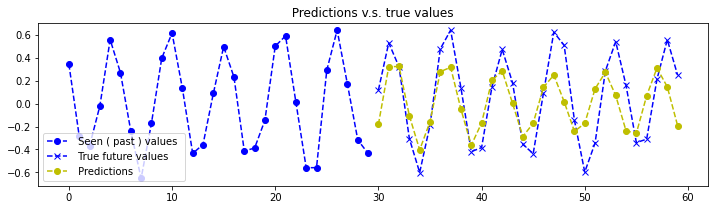

In [0]:
nb_predictions = 1
print (" Let 's visualize {} predictions with our signals :". format (nb_predictions ))
X, Y = generate_x_y_data_3( isTrain =False , batch_size = nb_predictions )
feed_dict = { enc_inp [t]: X[t] for t in range ( seq_length )}
outputs = np.array( sess.run([ reshaped_outputs ], feed_dict )[0])
# выводим предсказания по каждому пакету
for j in range ( nb_predictions ):
    plt.figure( figsize =(12 , 3))
    for k in range ( output_dim ):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]
    label1 = " Seen ( past ) values " if k ==0 else " _nolegend_ "
    label2 = " True future values " if k ==0 else " _nolegend_ "
    label3 = " Predictions " if k ==0 else " _nolegend_ "
    plt.plot(range(len(past)), past , "o--b", label = label1 )
    plt.plot(range(len(past),len(expected)+len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past),len(pred) + len (past)), pred , "o--y", label = label3 )
    plt.legend( loc ='best ')
    plt.title(" Predictions v.s. true values ")
    plt.show()